In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats

import plotly.express as px
import xarray as xr


import os 
import sys
p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))
from CryptoSent.tools.crypto_coin_actual import get_btc_actual_hourly

from CryptoSent.tools import evaluation as eval
from datetime import datetime
bc=pd.read_pickle("../Datasets/Main Dataset/bitcoin_comments.pickle")
bs=pd.read_pickle("../Datasets/Main Dataset/bitcoin_submissions.pickle")
bs['volume']=1
bc['buy']=bc.body_clean.str.contains('buy',case=False)
bc['sell']=bc.body_clean.str.contains('sell',case=False)
bc['volume']=1

btc_raw=get_btc_actual_hourly()

# Buy Sell

In [2]:

resample_period='w'
sent=bc
sent2=bs
sent=sent.resample(resample_period).sum().head(-1)
sent2=sent2.resample(resample_period).sum().head(-1)
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')


btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean().head(-1)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=sent2.index, y=sent2.buy, name=f"Post Buy"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=sent2.index, y=sent2.sell, name=f"Post Sell"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.buy, name="Comment Buy"),
    secondary_y=True,
)


fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sell, name="Comment Sell"),
    secondary_y=True,
)


# Add figure title
fig.update_layout(
    title_text=f"Buy - Sell for Posts & Comments"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Count</b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Comments  </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))

fig.show()




## Buy - Sell Scalled Average vs Price

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scl=MinMaxScaler()

resample_period='w'
sent=bc
sent2=bs
sent=sent.resample(resample_period).sum().head(-1)
sent2=sent2.resample(resample_period).sum().head(-1)
sent3=btc_raw[['close']].resample(resample_period).mean().head(-1).rename(columns={'close':'Bitcoin Price'})
a=sent[['buy','sell']].rename(columns={'buy':'comment_buy','sell':'comment_sell'})
b=sent2[['buy','sell']].rename(columns={'buy':'post_buy','sell':'post_sell'})
w=pd.concat([a,b,sent3],axis=1).dropna()    
q=pd.concat([w[['Bitcoin Price']],pd.DataFrame(scl.fit_transform(w.drop(columns='Bitcoin Price')),
             columns=w.drop(columns='Bitcoin Price').columns,
             index=w.drop(columns='Bitcoin Price').index)],axis=1).head(-1)




# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=q.index, y=q['Bitcoin Price'], name=f"Bitcoin Price"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=q.index, y=q[['comment_buy','post_buy']].mean(axis=1), name="Buy"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=q.index, y=q[['comment_sell','post_sell']].mean(axis=1), name="Sell"),
    secondary_y=False,
)


# Add figure title
fig.update_layout(
    title_text=f"Buy - Sell Compared to Bitcoin Price"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Buy - Sell Scaled </b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $  </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))
fig.add_annotation(x='2019-09-01', y=0.95,
            text=f"Spearman Correlation - \tBuy: {round(stats.spearmanr(q['Bitcoin Price'],q[['comment_buy','post_buy']].mean(axis=1))[0],2)} \t\t Sell: {round(stats.spearmanr(q['Bitcoin Price'],q[['comment_sell','post_sell']].mean(axis=1))[0],2)}",
            showarrow=False,
            secondary_y=True
            )
fig.add_annotation(x='2019-09-01', y=0.87,
             text=f"Pearson Correlation     - \tBuy: {round(stats.pearsonr(q['Bitcoin Price'],q[['comment_buy','post_buy']].mean(axis=1))[0],2)} \t\t Sell: {round(stats.pearsonr(q['Bitcoin Price'],q[['comment_sell','post_sell']].mean(axis=1))[0],2)}",
            showarrow=False,
            )
fig.show()

## Posts vs Price

In [4]:

resample_period='w'
sent=bs
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')

sent=sent.resample(resample_period).sum().head(-1)
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean().head(-1)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=btc.index, y=btc, name=f"Bitcoin Price"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.buy, name="Buy"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sell, name="Sell"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text=f"Buy - Sell Posts Compared to Bitcoin Price"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Buy - Sell Count </b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $  </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))
fig.add_annotation(x='2019-09-01', y=2000,
            text=f"Spearman Correlation - \tBuy: {round(stats.spearmanr(btc,sent.buy)[0],2)} \t\t Sell: {round(stats.spearmanr(btc,sent.sell)[0],2)}",
            showarrow=False,
            secondary_y=True
            )
fig.add_annotation(x='2019-09-01', y=1850,
             text=f"Pearson Correlation     - \tBuy: {round(stats.pearsonr(btc,sent.buy)[0],2)} \t\t Sell: {round(stats.pearsonr(btc,sent.sell)[0],2)}",
            showarrow=False,
            )
fig.show()

## Comments vs Price

In [5]:

resample_period='w'
sent=bc
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')

sent=sent.resample(resample_period).sum().head(-1)
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean().head(-1)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=btc.index, y=btc, name=f"Bitcoin Price"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.buy, name="Buy"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sell, name="Sell"),
    secondary_y=False,
)

# Add figure title
fig.update_layout(
    title_text=f"Buy - Sell Comments Compared to Bitcoin Price"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Buy - Sell Count </b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $  </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))
fig.add_annotation(x='2019-09-01', y=19000,
            text=f"Spearman Correlation - \tBuy: {round(stats.spearmanr(btc,sent.buy)[0],2)} \t\t Sell: {round(stats.spearmanr(btc,sent.sell)[0],2)}",
            showarrow=False,
            secondary_y=True
            )
fig.add_annotation(x='2019-09-01', y=17500,
             text=f"Pearson Correlation     - \tBuy: {round(stats.pearsonr(btc,sent.buy)[0],2)} \t\t Sell: {round(stats.pearsonr(btc,sent.sell)[0],2)}",
            showarrow=False,
            )
fig.show()

## Correlation Heatmap

In [256]:
resample_period='w'
sent=bc
sent2=bs
sent=sent.resample(resample_period).sum().head(-1)
sent2=sent2.resample(resample_period).sum().head(-1)
sent3=btc_raw[['close']].resample(resample_period).mean().head(-1).rename(columns={'close':'Bitcoin Price'})
a=sent[['buy','sell']].rename(columns={'buy':'comment_buy','sell':'comment_sell'})
b=sent2[['buy','sell']].rename(columns={'buy':'post_buy','sell':'post_sell'})
c=pd.concat([a,b],axis=1).dropna().head(-1).corr(method='pearson')

# Load xarray from dataset included in the xarray tutorial
#airtemps = xr.tutorial.open_dataset('air_temperature').air.sel(lon=250.0)
fig = px.imshow(c, color_continuous_scale='RdBu_r', origin='lower')
# Add figure title
fig.update_layout(
    title_text=f"Pearson Correlation"
)
# Set x-axis title


fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = 0.5,
    xaxis_title="",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)
fig.show()

# NTUSD

## NTUSD all signals

In [16]:
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
resample_period='w'
sent=bs
sent2=bc
sent=sent.resample(resample_period).sum().head(-1)
sent2=sent2.resample(resample_period).sum().head(-1)
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean()#.head(-1)
a=sent[['sent_ntusd','sent_ntusd_wavg']].rename(columns={'sent_ntusd':'ntusd_post','sent_ntusd_wavg':'ntusd_post_wavg'})
b=sent2[['sent_ntusd','sent_ntusd_wavg']].rename(columns={'sent_ntusd':'ntusd_comment','sent_ntusd_wavg':'ntusd_comment_wavg'})
c=pd.concat([a,b],axis=1)
d=pd.DataFrame(scl.fit_transform(c),columns=c.columns,index=c.index)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])



# Add traces
fig.add_trace(
    go.Scatter(x=d.index, y=d.ntusd_post, name=f"Post"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=d.index, y=d.ntusd_comment, name="Comment"),
    secondary_y=False,
)

# Add traces
fig.add_trace(
    go.Scatter(x=d.index, y=d.ntusd_post_wavg, name=f"w-avg Post"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=d.index, y=d.ntusd_comment_wavg, name="w-avg Comment"),
    secondary_y=False,
)



# Add figure title
fig.update_layout(
    title_text=f"NTUSD-fin for Posts & Comments"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Scaled</b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $ </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))
fig.show()




## NTUSD wavg vs PRice

In [17]:
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
resample_period='w'
sent=bs
sent2=bc
sent=sent.resample(resample_period).sum().head(-1)
sent2=sent2.resample(resample_period).sum().head(-1)
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean()#.head(-1)
a=sent[['sent_ntusd','sent_ntusd_wavg']].rename(columns={'sent_ntusd':'ntusd_post','sent_ntusd_wavg':'ntusd_post_wavg'})
b=sent2[['sent_ntusd','sent_ntusd_wavg']].rename(columns={'sent_ntusd':'ntusd_comment','sent_ntusd_wavg':'ntusd_comment_wavg'})
c=pd.concat([a,b],axis=1)
d=pd.DataFrame(scl.fit_transform(c),columns=c.columns,index=c.index)
#pq=d[['ntusd_post','ntusd_post_wavg']].mean(axis=1)
#cq=d[['ntusd_comment','ntusd_comment_wavg']].mean(axis=1)
pq=d['ntusd_post_wavg']
cq=d['ntusd_comment_wavg']

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add traces
fig.add_trace(
    go.Scatter(x=btc.index, y=btc, name=f"Bitcoin Price"),
    secondary_y=True,
)

# Add traces
fig.add_trace(
    go.Scatter(x=d.index, y=pq, name=f"Post"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=d.index, y=cq, name="Comment"),
    secondary_y=False,
)



# Add figure title
fig.update_layout(
    title_text=f"NTUSD-fin for Posts & Comments"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Scaled</b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $ </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))
fig.add_annotation(x='2019-09-01', y=0.95,
            text=f"Spearman Correlation - \tPost: {round(stats.spearmanr(btc,pq)[0],2)} \t\t Comment: {round(stats.spearmanr(btc,cq)[0],2)}",
            showarrow=False,
            secondary_y=True
            )

fig.add_annotation(x='2019-09-01', y=.87,
             text=f"Pearson Correlation  - \tPost: {round(stats.pearsonr(btc,pq)[0],2)} \t\t Comment: {round(stats.pearsonr(btc,cq)[0],2)}",
            showarrow=False,
            )
fig.show()




# LR

In [132]:
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
resample_period='w'
sent=bs[['sent_lr']]
sent2=bc
sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sent=sent.resample(resample_period).sum().head(-1)
sent2=sent2.resample(resample_period).sum().head(-1)
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean()#.head(-1)
a=sent[['sent_lr']].rename(columns={'sent_lr':'lr_post'})
b=sent2[['sent_lr']].rename(columns={'sent_lr':'lr_comment'})
c=pd.concat([a,b],axis=1)
d=pd.DataFrame(scl.fit_transform(c),columns=c.columns,index=c.index)
#pq=d[['ntusd_post','ntusd_post_wavg']].mean(axis=1)
#cq=d[['ntusd_comment','ntusd_comment_wavg']].mean(axis=1)
pq=d['lr_post']
cq=d['lr_comment']
pcavg=d.mean(axis=1)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])


# Add traces
fig.add_trace(
    go.Scatter(x=btc.index, y=btc, name=f"Bitcoin Price"),
    secondary_y=True,
)

# Add traces
fig.add_trace(
    go.Scatter(x=d.index, y=pq, name=f"Post"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=d.index, y=cq, name="Comment"),
    secondary_y=False,
)



# Add figure title
fig.update_layout(
    title_text=f"Logistic Regression for Posts & Comments"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Scaled</b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $ </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))
fig.add_annotation(x='2019-09-01', y=0.95,
            text=f"Spearman Correlation - \tPost: {round(stats.spearmanr(btc,pq)[0],2)} \t\t Comment: {round(stats.spearmanr(btc,cq)[0],2)}",
            showarrow=False,
            secondary_y=True
            )

fig.add_annotation(x='2019-09-01', y=.87,
             text=f"Pearson Correlation  - \tPost: {round(stats.pearsonr(btc,pq)[0],2)} \t\t Comment: {round(stats.pearsonr(btc,cq)[0],2)}",
            showarrow=False,
            )
fig.show()




# Distil BERT

In [6]:
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
resample_period='w'
sent=bs[['sent_lr']]

sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sent=sent.resample(resample_period).sum().head(-1)
sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean()#.head(-1)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=btc.index, y=btc, name=f"Bitcoin Price"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sent_lr, name="Distil BERT"),
    secondary_y=False,
)


# Add figure title
fig.update_layout(
    title_text=f"Distil BERT Compared to Bitcoin Price"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Scaled</b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $  </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))
fig.add_annotation(x='2019-09-01', y=0.97,
            text=f"Spearman Correlation: {round(stats.spearmanr(btc,sent.sent_lr)[0],2)} ",
            showarrow=False,
            secondary_y=True
            )
fig.add_annotation(x='2019-09-01', y=0.9,
             text=f"Pearson Correlation:     {round(stats.pearsonr(btc,sent.sent_lr)[0],2)}",
            showarrow=False,
            )
fig.show()

# fin BERT

In [7]:
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
resample_period='w'
sent=bs[['sent_fb']]

sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sent=sent.resample(resample_period).sum().head(-1)
sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean()#.head(-1)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=btc.index, y=btc, name=f"Bitcoin Price"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sent_fb, name="finBERT"),
    secondary_y=False,
)


# Add figure title
fig.update_layout(
    title_text=f"finBERT Compared to Bitcoin Price"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment  Scaled</b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $  </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))
fig.add_annotation(x='2019-09-01', y=.97,
            text=f"Spearman Correlation: {round(stats.spearmanr(btc,sent.sent_fb)[0],2)} ",
            showarrow=False,
            secondary_y=True
            )
fig.add_annotation(x='2019-09-01', y=.9,
             text=f"Pearson Correlation:      {round(stats.pearsonr(btc,sent.sent_fb)[0],2)}",
            showarrow=False,
            )
fig.show()

# fin BERT Tone

In [8]:
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
resample_period='w'
sent=bs[['sent_fbt']]

sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sent=sent.resample(resample_period).sum().head(-1)
sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean()#.head(-1)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=btc.index, y=btc, name=f"Bitcoin Price"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sent_fbt, name="finBERT Tone"),
    secondary_y=False,
)


# Add figure title
fig.update_layout(
    title_text=f"finBERT Tone Compared to Bitcoin Price"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Scaled</b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $  </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3.7))
fig.add_annotation(x='2019-09-01', y=.97,
            text=f"Spearman Correlation: {round(stats.spearmanr(btc,sent.sent_fbt)[0],2)} ",
            showarrow=False,
            secondary_y=True
            )
fig.add_annotation(x='2019-09-01', y=.9,
             text=f"Pearson Correlation:      {round(stats.pearsonr(btc,sent.sent_fbt)[0],2)}",
            showarrow=False,
            )
fig.show()

# Distil BERT Emotion

In [2]:
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
resample_period='w'
sent=bs[['sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise']]

sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sent=sent.resample(resample_period).sum().head(-1)
sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean()#.head(-1)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=btc.index, y=btc, name=f"Bitcoin Price"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sent_dbe_sadness, name="Sadness"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sent_dbe_joy, name="Joy"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sent_dbe_love, name="Love"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sent_dbe_anger, name="Anger"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sent_dbe_fear, name="Fear"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=sent.index, y=sent.sent_dbe_surprise, name="Surprise"),
    secondary_y=False,
)


# Add figure title
fig.update_layout(
    title_text=f"DistilBERT Emotion Compared to Bitcoin Price"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Scaled</b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin Price USD $  </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)


fig.update_traces(line=dict( width=3.7))

fig.show()

In [508]:
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
resample_period='w'
sent=bs[['sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise']]

sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sent=sent.resample(resample_period).mean().head(-1)
sent=pd.DataFrame(scl.fit_transform(sent),columns=sent.columns,index=sent.index)
sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean()#.head(-1)
c=pd.concat([sent],axis=1).corr()


# Load xarray from dataset included in the xarray tutorial
#airtemps = xr.tutorial.open_dataset('air_temperature').air.sel(lon=250.0)
fig = px.imshow(c, color_continuous_scale='RdBu_r', origin='lower')
# Add figure title
fig.update_layout(
    title_text=f"Emotion Correlation"
)
# Set x-axis title


fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = 0.5,
    xaxis_title="",
    #yaxis_title="Number of Posts",
    width=1500, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)
fig.show()

# RESULTS

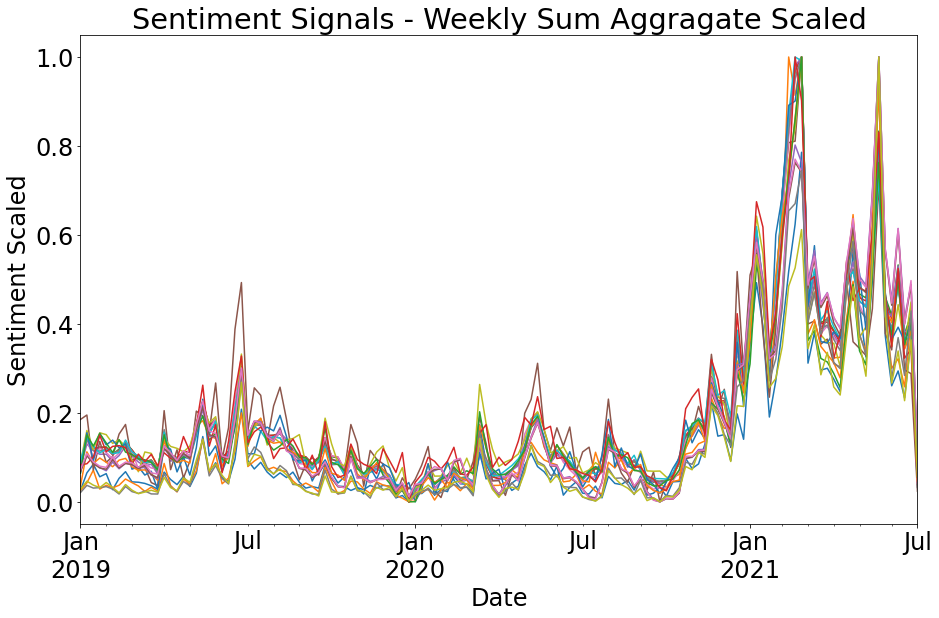

In [323]:
scl1=MinMaxScaler(feature_range=(-1,1))
scl2=MinMaxScaler(feature_range=(0,1))
resample_var='w'
a=bs[['sell', 'buy',
       'sent_ntusd', 'sent_ntusd_wavg', 'sent_lr', 'sent_db', 'sent_fb',
       'sent_fbt', 'sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise','volume']]
a=pd.DataFrame(scl2.fit_transform(a),columns=a.columns,index=a.index).resample(resample_var).sum()
b=bc[['sent_lr','sent_ntusd','sent_ntusd_wavg','buy','sell','volume']]\
    .rename(columns={'sent_lr':'sent_lr_coms','sent_ntusd':'sent_ntusd_coms','sent_ntusd_wavg':'sent_ntusd_wavg_coms',
                     'buy':'buy_coms','sell':'sell_coms','volume':'volume_coms'})
b=pd.DataFrame(scl2.fit_transform(b),columns=b.columns,index=b.index).resample(resample_var).sum()
c=pd.concat([a,b],axis=1)
c=pd.DataFrame(scl2.fit_transform(c),columns=c.columns,index=c.index).drop(columns=['volume','volume_coms'])


plt.rcParams["figure.figsize"] = (15,9)
plt.rcParams.update({'font.size': 24})
#plt.figure()

c.plot(legend=False)
plt.xlabel('Date')
plt.ylabel('Sentiment Scaled')
plt.title('Sentiment Signals - Weekly Sum Aggragate Scaled')
#fig.tight_layout()
plt.savefig('all_signals_sum_w.png',bbox_inches='tight')
plt.show()





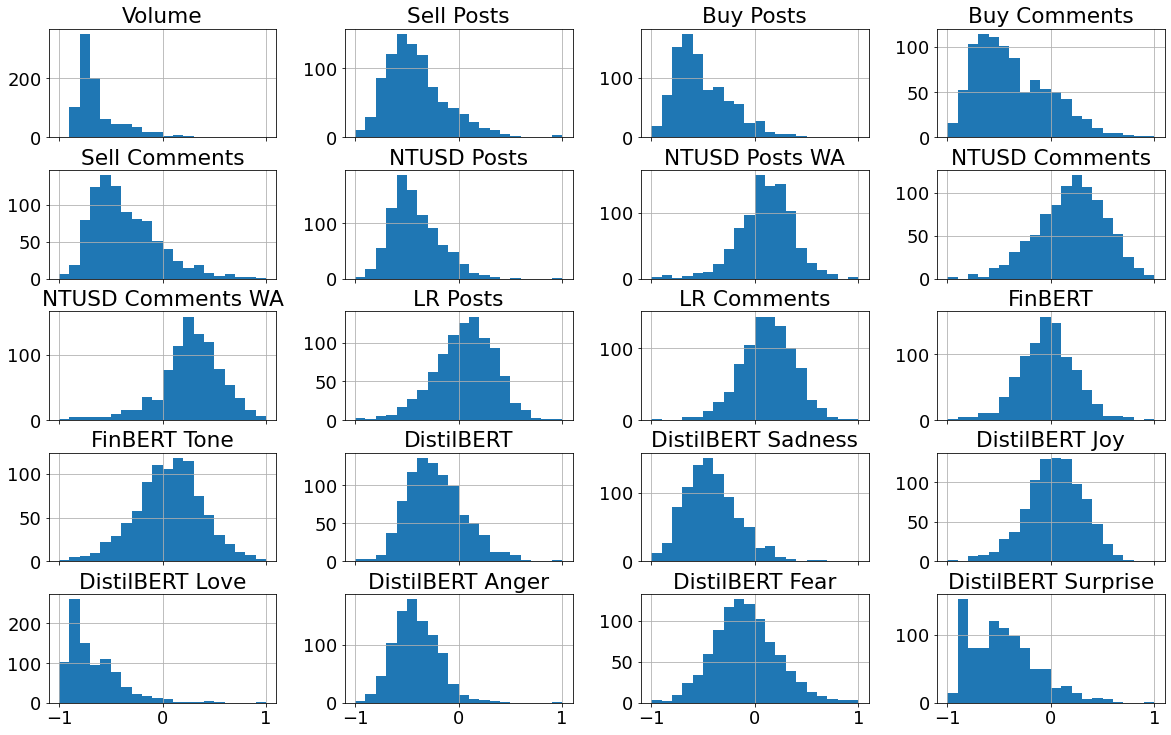

In [134]:
scl=MinMaxScaler(feature_range=(-1,1))
resample_var='d'
a=bs[['sell', 'buy',
       'sent_ntusd', 'sent_ntusd_wavg', 'sent_lr', 'sent_db', 'sent_fb',
       'sent_fbt', 'sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise','volume']].drop(columns='volume')
a=pd.DataFrame(scl.fit_transform(a),columns=a.columns,index=a.index).resample(resample_var).mean()
b=bc[['sent_lr','sent_ntusd','sent_ntusd_wavg','buy','sell','volume']]\
    .rename(columns={'sent_lr':'sent_lr_coms','sent_ntusd':'sent_ntusd_coms','sent_ntusd_wavg':'sent_ntusd_wavg_coms',
                     'buy':'buy_coms','sell':'sell_coms','volume':'volume_coms'}).drop(columns=['volume_coms'])
b=pd.DataFrame(scl.fit_transform(b),columns=b.columns,index=b.index).resample(resample_var).mean()
c=pd.concat([a,b],axis=1)
c=pd.DataFrame(scl.fit_transform(c),columns=c.columns,index=c.index)
c=c[['sell', 'buy', 'buy_coms','sell_coms',
    'sent_ntusd', 'sent_ntusd_wavg', 'sent_ntusd_coms', 'sent_ntusd_wavg_coms',
    'sent_lr', 'sent_lr_coms',
    'sent_fb', 'sent_fbt','sent_db',
    'sent_dbe_sadness', 'sent_dbe_joy','sent_dbe_love', 'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise',
         ]]

c=c.rename(columns={'sell':'Sell Posts', 'buy':'Buy Posts', 'buy_coms':'Buy Comments','sell_coms':'Sell Comments',
'sent_ntusd':'NTUSD Posts', 'sent_ntusd_wavg':'NTUSD Posts WA', 'sent_ntusd_coms':'NTUSD Comments', 'sent_ntusd_wavg_coms':'NTUSD Comments WA',
'sent_lr':'LR Posts', 'sent_lr_coms': 'LR Comments',
'sent_fb':'FinBERT', 'sent_fbt':'FinBERT Tone','sent_db':'DistilBERT',
'sent_dbe_sadness':'DistilBERT Sadness', 'sent_dbe_joy':'DistilBERT Joy','sent_dbe_love':'DistilBERT Love', 'sent_dbe_anger':'DistilBERT Anger', 
'sent_dbe_fear':'DistilBERT Fear', 'sent_dbe_surprise':'DistilBERT Surprise',
        })

t1=bs[['volume']].rename(columns={'volume':'Volume'}).resample(resample_var).sum()
t1=pd.DataFrame(scl.fit_transform(t1),columns=t1.columns,index=t1.index)

c=pd.concat([t1,c],axis=1)
c.index=c.index.rename('Date')

#plt.xlim(-1, 1)
plt.rcParams["figure.figsize"] = (15,9)
plt.rcParams.update({'font.size': 18})
c.hist(figsize=(20,15),sharex=True,layout=(6,4),bins=20,grid=True,sharey=False);
#plt.xlabel('Comments - Log')
#plt.ylabel('Count of Authors')
#plt.title('Comments per Author Distribution - Log Scalled')

plt.savefig('signal_hist_avg_d.png',bbox_inches='tight')

plt.show()


In [137]:
scl=MinMaxScaler(feature_range=(0,1))
resample_var='w'
a=bs[['sell', 'buy',
       'sent_ntusd', 'sent_ntusd_wavg', 'sent_lr', 'sent_db', 'sent_fb',
       'sent_fbt', 'sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise','volume']].drop(columns='volume')
a=pd.DataFrame(scl.fit_transform(a),columns=a.columns,index=a.index).resample(resample_var).mean()
b=bc[['sent_lr','sent_ntusd','sent_ntusd_wavg','buy','sell','volume']]\
    .rename(columns={'sent_lr':'sent_lr_coms','sent_ntusd':'sent_ntusd_coms','sent_ntusd_wavg':'sent_ntusd_wavg_coms',
                     'buy':'buy_coms','sell':'sell_coms','volume':'volume_coms'}).drop(columns=['volume_coms'])
b=pd.DataFrame(scl.fit_transform(b),columns=b.columns,index=b.index).resample(resample_var).mean()
c=pd.concat([a,b],axis=1)
c=pd.DataFrame(scl.fit_transform(c),columns=c.columns,index=c.index)

c=c[['sell', 'buy', 'buy_coms','sell_coms',
    'sent_ntusd', 'sent_ntusd_wavg', 'sent_ntusd_coms', 'sent_ntusd_wavg_coms',
    'sent_lr', 'sent_lr_coms',
    'sent_fb', 'sent_fbt','sent_db',
    'sent_dbe_sadness', 'sent_dbe_joy','sent_dbe_love', 'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise',
         ]]

c=c.rename(columns={'sell':'Sell Posts', 'buy':'Buy Posts', 'buy_coms':'Buy Comments','sell_coms':'Sell Comments',
    'sent_ntusd':'NTUSD Posts', 'sent_ntusd_wavg':'NTUSD Posts WA', 'sent_ntusd_coms':'NTUSD Comments', 'sent_ntusd_wavg_coms':'NTUSD Comments WA',
    'sent_lr':'LR Posts', 'sent_lr_coms': 'LR Comments',
    'sent_fb':'FinBERT', 'sent_fbt':'FinBERT Tone','sent_db':'DistilBERT',
    'sent_dbe_sadness':'DistilBERT Sadness', 'sent_dbe_joy':'DistilBERT Joy','sent_dbe_love':'DistilBERT Love', 'sent_dbe_anger':'DistilBERT Anger', 
    'sent_dbe_fear':'DistilBERT Fear', 'sent_dbe_surprise':'DistilBERT Surprise',
         })
c.index=c.index.rename('Date')
t1=bs[['volume']].rename(columns={'volume':'Volume'}).resample(resample_var).sum()
t1=pd.DataFrame(scl.fit_transform(t1),columns=t1.columns,index=t1.index)

c=pd.concat([t1,c],axis=1)
c.index=c.index.rename('Date')
#a.plot(figsize=(15,10),legend=False)
import plotly.express as px

fig = px.line(c, facet_col="variable", facet_col_wrap=5)


fig.update_layout(
    #title="Sentiment Signals - Weekly Average",
    title_x = .5,
    title_y = 1,
    #xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1500, height=950,
    font=dict(
        #family="Courier New, monospace",
        size=20,
        #color="RebeccaPurple"
    )
)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_layout(showlegend=False)


fig.update_layout(

    width=1500, height=1000,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)


fig.show()

In [136]:
scl=MinMaxScaler(feature_range=(0,1))
resample_var='w'
btc=btc_raw.rename(columns={'close':'Bitcoin Price'})['Bitcoin Price'].resample(resample_var).mean()
a=bs[['sell', 'buy',
       'sent_ntusd', 'sent_ntusd_wavg', 'sent_lr', 'sent_db', 'sent_fb',
       'sent_fbt', 'sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise','volume']].drop(columns='volume')
a=pd.DataFrame(scl.fit_transform(a),columns=a.columns,index=a.index).resample(resample_var).mean()
b=bc[['sent_lr','sent_ntusd','sent_ntusd_wavg','buy','sell','volume']]\
    .rename(columns={'sent_lr':'sent_lr_coms','sent_ntusd':'sent_ntusd_coms','sent_ntusd_wavg':'sent_ntusd_wavg_coms',
                     'buy':'buy_coms','sell':'sell_coms','volume':'volume_coms'}).drop(columns=['volume_coms'])
b=pd.DataFrame(scl.fit_transform(b),columns=b.columns,index=b.index).resample(resample_var).mean()
c=pd.concat([a,b],axis=1)
c=pd.DataFrame(scl.fit_transform(c),columns=c.columns,index=c.index)
c=c[[
    'sent_ntusd', 'sent_ntusd_wavg', 'sent_ntusd_coms', 'sent_ntusd_wavg_coms',
    'sent_lr', 'sent_lr_coms',
    'sent_fb', 'sent_fbt','sent_db',
    'sent_dbe_sadness', 'sent_dbe_joy','sent_dbe_love', 'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise',
         ]]
c=c.rename(columns={
    'sent_ntusd':'NTUSD Posts', 'sent_ntusd_wavg':'NTUSD Posts WA', 'sent_ntusd_coms':'NTUSD Comments', 'sent_ntusd_wavg_coms':'NTUSD Comments WA',
    'sent_lr':'LR Posts', 'sent_lr_coms': 'LR Comments',
    'sent_fb':'FinBERT', 'sent_fbt':'FinBERT Tone','sent_db':'DistilBERT',
    'sent_dbe_sadness':'DistilBERT Sadness', 'sent_dbe_joy':'DistilBERT Joy','sent_dbe_love':'DistilBERT Love', 'sent_dbe_anger':'DistilBERT Anger', 
    'sent_dbe_fear':'DistilBERT Fear', 'sent_dbe_surprise':'DistilBERT Surprise',
         })
c.index=c.index.rename('Date')
d=pd.concat([c,btc.pct_change()],axis=1).dropna()


# Load xarray from dataset included in the xarray tutorial
#airtemps = xr.tutorial.open_dataset('air_temperature').air.sel(lon=250.0)
fig = px.imshow(d.corr(), color_continuous_scale='RdBu_r', origin='lower')
# Add figure title
fig.update_layout(
    title_text=f"Sentiment Signals Correlation"
)
# Set x-axis title


fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = 0.5,
    xaxis_title="",
    #yaxis_title="Number of Posts",
    width=1500, height=1000,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)
fig.show()

# Emotion Comparison KDE

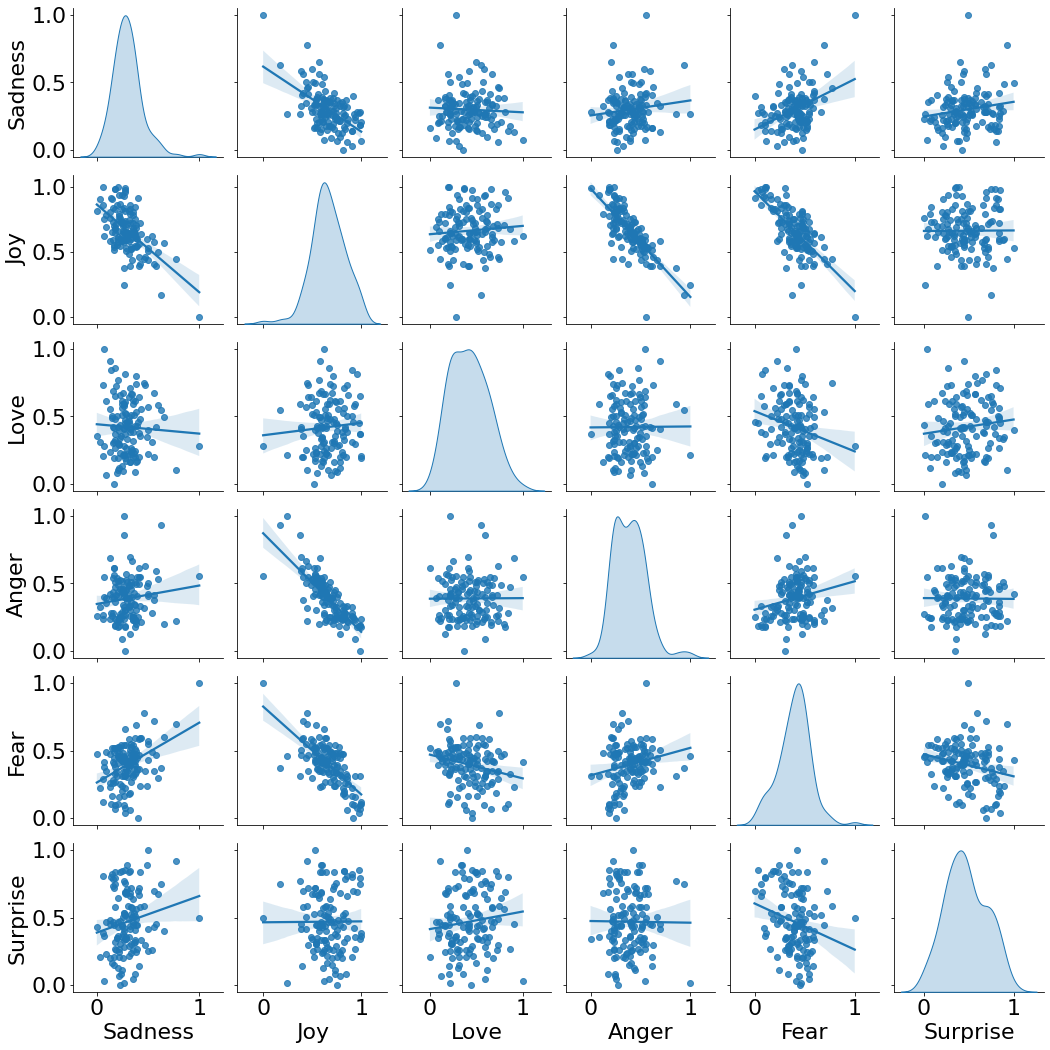

In [14]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler(feature_range=(0,1))
resample_var='w'
a=bs[['sell', 'buy',
       'sent_ntusd', 'sent_ntusd_wavg', 'sent_lr', 'sent_db', 'sent_fb',
       'sent_fbt', 'sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise','volume']].drop(columns='volume')
a=pd.DataFrame(scl.fit_transform(a),columns=a.columns,index=a.index).resample(resample_var).mean()
b=bc[['sent_lr','sent_ntusd','sent_ntusd_wavg','buy','sell','volume']]\
    .rename(columns={'sent_lr':'sent_lr_coms','sent_ntusd':'sent_ntusd_coms','sent_ntusd_wavg':'sent_ntusd_wavg_coms',
                     'buy':'buy_coms','sell':'sell_coms','volume':'volume_coms'}).drop(columns=['volume_coms'])
b=pd.DataFrame(scl.fit_transform(b),columns=b.columns,index=b.index).resample(resample_var).mean()
c=pd.concat([a,b],axis=1)
c=pd.DataFrame(scl.fit_transform(c),columns=c.columns,index=c.index)
c=c[['sell', 'buy', 'buy_coms','sell_coms',
    'sent_ntusd', 'sent_ntusd_wavg', 'sent_ntusd_coms', 'sent_ntusd_wavg_coms',
    'sent_lr', 'sent_lr_coms',
    'sent_fb', 'sent_fbt','sent_db',
    'sent_dbe_sadness', 'sent_dbe_joy','sent_dbe_love', 'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise',
         ]]

c=c.rename(columns={'sell':'Sell Posts', 'buy':'Buy Posts', 'buy_coms':'Buy Comments','sell_coms':'Sell Comments',
    'sent_ntusd':'NTUSD Posts', 'sent_ntusd_wavg':'NTUSD Posts WA', 'sent_ntusd_coms':'NTUSD Comments', 'sent_ntusd_wavg_coms':'NTUSD Comments WA',
    'sent_lr':'LR Posts', 'sent_lr_coms': 'LR Comments',
    'sent_fb':'FinBERT', 'sent_fbt':'FinBERT Tone','sent_db':'DistilBERT',
    'sent_dbe_sadness':'Sadness', 'sent_dbe_joy':'Joy','sent_dbe_love':'Love', 'sent_dbe_anger':'Anger', 
    'sent_dbe_fear':'Fear', 'sent_dbe_surprise':'Surprise',
         })
c.index=c.index.rename('Date')
t1=bs[['volume']].rename(columns={'volume':'Volume'}).resample(resample_var).sum()
t1=pd.DataFrame(scl.fit_transform(t1),columns=t1.columns,index=t1.index)

c=pd.concat([t1,c],axis=1)
c.index=c.index.rename('Date')



t3=c[['Sadness', 'Joy', 'Love',
       'Anger', 'Fear', 'Surprise']]


plt.rcParams["figure.figsize"] = (15,9)
plt.rcParams.update({'font.size': 22})
#plt.figure()
sns.pairplot(t3, kind="reg", diag_kind="kde")

plt.savefig('emotion_sns.png',bbox_inches='tight')
plt.show()




# Discussion

In [4]:
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
resample_period='d'


scl1=MinMaxScaler(feature_range=(-1,1))
scl2=MinMaxScaler(feature_range=(-1,1))
resample_var='d'
a=bs[['sell', 'buy',
       'sent_ntusd', 'sent_ntusd_wavg', 'sent_lr', 'sent_db', 'sent_fb',
       'sent_fbt', 'sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise','volume']]
a=pd.DataFrame(scl2.fit_transform(a),columns=a.columns,index=a.index).resample(resample_period).mean()
b=bc[['sent_lr','sent_ntusd','sent_ntusd_wavg','buy','sell','volume']]\
    .rename(columns={'sent_lr':'sent_lr_coms','sent_ntusd':'sent_ntusd_coms','sent_ntusd_wavg':'sent_ntusd_wavg_coms',
                     'buy':'buy_coms','sell':'sell_coms','volume':'volume_coms'})
b=pd.DataFrame(scl2.fit_transform(b),columns=b.columns,index=b.index).resample(resample_period).mean()
c=pd.concat([a,b],axis=1)
c=pd.DataFrame(scl2.fit_transform(c),columns=c.columns,index=c.index).drop(columns=['volume','volume_coms'])
c=c[['sent_fb']]
t1=pd.concat([btc_raw.close.resample(resample_period).mean(),c.mean(axis=1)],axis=1).dropna().rename(columns={0:'average_sentiment'})
t1=t1.loc['2021-02':'2021-06']
sdmin=datetime.strftime(t1.index.min(),'%Y-%m-%d')
sdmax=datetime.strftime(t1.index.max(),'%Y-%m-%d')
btc=btc_raw[sdmin:sdmax].close.resample(resample_period).mean().pct_change().dropna()#.head(-1)


In [14]:


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=btc.index, y=btc, name=f"Bitcoin"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x=t1.index, y=t1.average_sentiment, name="FinBERT Sentiment", line=dict(color='#D9A21E') ),
    secondary_y=False,
   
)


# Add figure title
fig.update_layout(
    title_text=f"FinBERT Compared to Bitcoin % Change - Daily Average - 2021 1H"
)
# Set x-axis title
fig.update_xaxes(title_text="Date")
# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Scaled</b>", secondary_y=False)
fig.update_yaxes(title_text=f"<b>Bitcoin % Change  </b>", secondary_y=True)

fig.update_layout(
    #title="Top 3 Subreddit Post Trend - Weekly",
    title_x = .09,
    xaxis_title="Date",
    #yaxis_title="Number of Posts",
    width=1900, height=750,
    font=dict(
        #family="Courier New, monospace",
        size=24,
        #color="RebeccaPurple"
    )
)

fig.update_layout(legend=dict(
    title='',
    orientation="h",
    yanchor="bottom",
    y=1.07,
    xanchor="right",
    x=0.945
    )
    )
fig.update_traces(line=dict( width=3))

#fig.add_vrect(x0="2021-01-01", x1="2021-01-26", fillcolor="green", opacity=0.15, line_width=2) #annotation_text="Align", annotation_position="top right",annotation=dict(font_size=39),
#fig.add_vrect(x0="2021-01-26", x1="2021-02-06", fillcolor="gray", opacity=0.5, line_width=2)
#fig.add_vrect(x0="2021-02-06", x1="2021-02-28", fillcolor="green", opacity=0.15, line_width=2)
fig.add_vrect(x0="2021-02-28", x1="2021-03-07", fillcolor="red", opacity=0.15, line_width=2)              
#fig.add_vrect(x0="2021-03-07", x1="2021-03-20", fillcolor="green", opacity=0.15, line_width=2)     
fig.add_vrect(x0="2021-03-21", x1="2021-03-24", fillcolor="red", opacity=0.15, line_width=2)
fig.add_vrect(x0="2021-04-05", x1="2021-04-9", fillcolor="red", opacity=0.15, line_width=2)
fig.add_vrect(x0="2021-04-27", x1="2021-05-08", fillcolor="red", opacity=0.15, line_width=2)                              
fig.add_vrect(x0="2021-06-15", x1="2021-06-30", fillcolor="red", opacity=0.15, line_width=2)              


#fig.add_vline(x='2021-4-28',line_dash="dash",line_width=1,line=dict(color='black'))
fig.add_vline(x='2021-5-21',line_width=1,line=dict(color='black'))
#fig.add_vline(x='2021-5-25', line_width=1,line=dict(color='black'))
#fig.add_vline(x='2021-6-09', line_dash="dash",line_width=1,line=dict(color='black'))
fig.add_vline(x='2021-6-13', line_dash="dash",line_width=1.2,line=dict(color='black'))

fig.show()

# Wordcloud


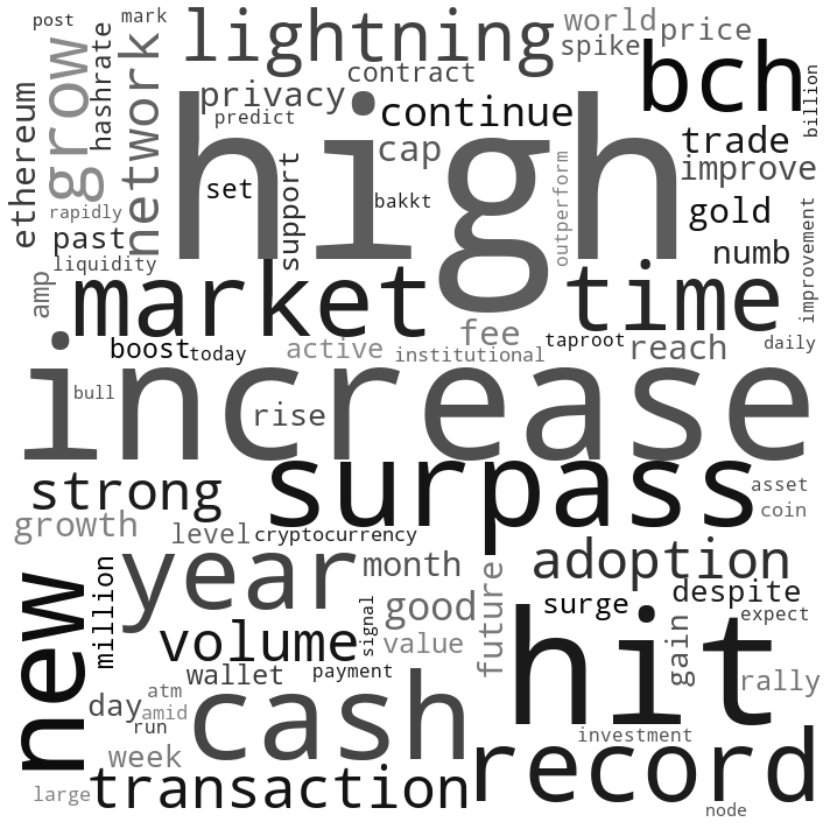

In [5]:
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
scl=MinMaxScaler()
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,0%%, %d%%)" % np.random.randint(0,55))
a=bs[['sell', 'buy',
       'sent_ntusd', 'sent_ntusd_wavg', 'sent_lr', 'sent_db', 'sent_fb',
       'sent_fbt', 'sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise','volume']]
a=pd.DataFrame(scl.fit_transform(a),columns=a.columns,index=a.index)
scl=MinMaxScaler()
scl=MinMaxScaler(feature_range=(0,1))
sentiment_signals=['sell', 'buy',
       'sent_ntusd', 'sent_ntusd_wavg', 'sent_lr', 'sent_db', 'sent_fb',
       'sent_fbt', 'sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise','volume']

a=bs[sentiment_signals]
c=pd.concat([a,bs[['clean_text']]],axis=1)

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 18})
stopwords1=['bitcoin','btc','s','crypto']

fig = plt.figure()

context=" ".join(review for review in c[c['sent_fb']>0.85].clean_text)
wc = WordCloud(width=700,height=700,background_color="white",contour_color='black',contour_width=3,
stopwords=stopwords1,collocations=False,max_font_size=190,colormap='gist_gray',max_words=80).generate(context)
wc.recolor(color_func = grey_color_func)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud_fb_positive.png')
plt.show()




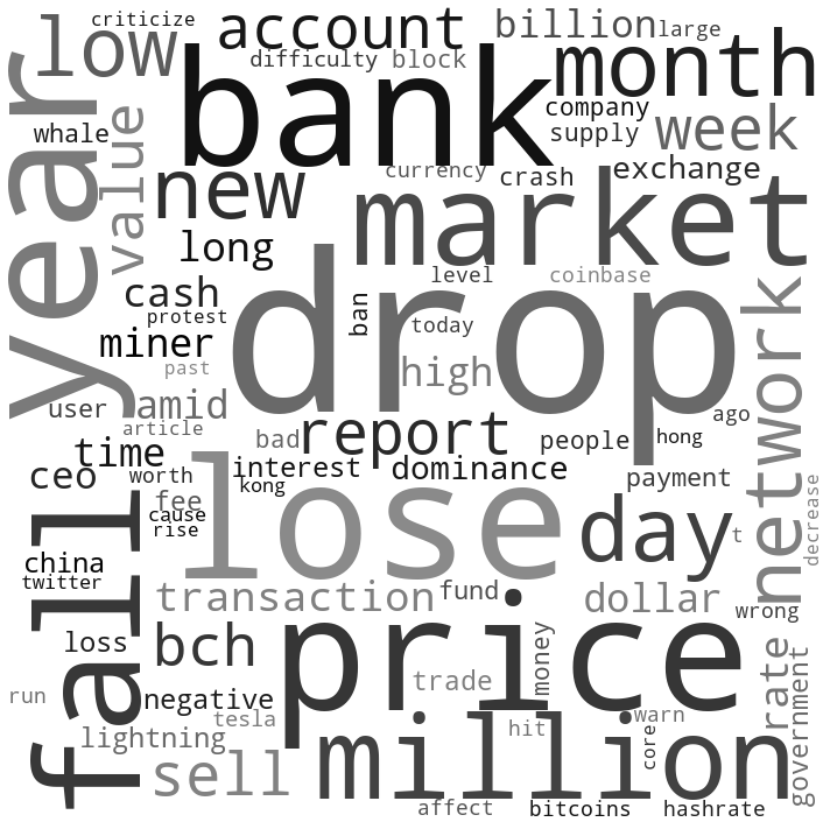

In [6]:


context=" ".join(review for review in c[c['sent_fb']<-0.8].clean_text)

wc = WordCloud(width=700,height=700,background_color="white",contour_color='black',contour_width=3,
stopwords=stopwords1,collocations=False,max_font_size=190,colormap='gist_gray',max_words=80).generate(context)
#change the color setting
wc.recolor(color_func = grey_color_func)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud_fb_negative.png')
plt.show()






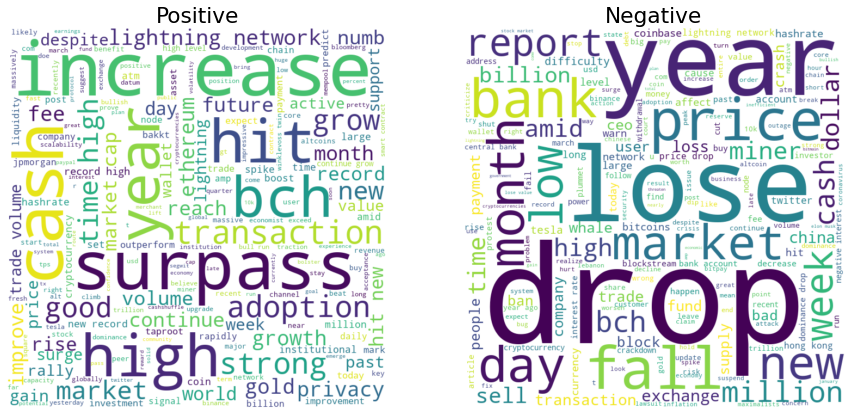

In [317]:
import wordcloud

scl=MinMaxScaler()
scl=MinMaxScaler(feature_range=(0,1))
sentiment_signals=['sell', 'buy',
       'sent_ntusd', 'sent_ntusd_wavg', 'sent_lr', 'sent_db', 'sent_fb',
       'sent_fbt', 'sent_dbe_sadness', 'sent_dbe_joy', 'sent_dbe_love',
       'sent_dbe_anger', 'sent_dbe_fear', 'sent_dbe_surprise','volume']
a=pd.DataFrame(scl.fit_transform(a),columns=a.columns,index=a.index)
a=bs[sentiment_signals]
c=pd.concat([a,bs[['clean_text']]],axis=1)

plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 18})
stopwords1=['bitcoin','btc','s','crypto']

fig = plt.figure()
ax1=fig.add_subplot(121)
ax1.title.set_text('Positive')
context=" ".join(review for review in c[c['sent_fb']>0.85].clean_text)
wc = wordcloud.WordCloud(width=700,height=700,background_color="white",stopwords=stopwords1,collocations=True).generate(context)
ax1.imshow(wc, interpolation='bilinear')
ax1.axis("off")
ax2=fig.add_subplot(122)
ax2.title.set_text('Negative')
context=" ".join(review for review in c[c['sent_fb']<-0.8].clean_text)
wc = wordcloud.WordCloud(width=700,height=700,background_color="white",stopwords=stopwords1,collocations=True).generate(context)
ax2.imshow(wc, interpolation='bilinear')
ax2.axis("off")

plt.show()



